In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random as rn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)


In [91]:
aids = pd.read_csv('data/AIDS_Classification.csv')

In [92]:
aids.shape

(2139, 23)

In [93]:
aids.describe()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,...,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,1.520804,35.248247,75.125311,0.084151,0.661057,0.131370,95.446470,0.021973,0.550257,...,0.585788,1.979897,0.172978,0.751286,0.362786,350.501169,371.307153,986.627396,935.369799,0.243572
std,292.274324,1.127890,8.709026,13.263164,0.277680,0.473461,0.337883,5.900985,0.146629,0.497584,...,0.492701,0.899053,0.378317,0.432369,0.480916,118.573863,144.634909,480.197750,444.976051,0.429338
min,14.000000,0.000000,12.000000,31.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,49.000000,40.000000,124.000000,0.000000
25%,727.000000,1.000000,29.000000,66.679200,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,263.500000,269.000000,654.000000,631.500000,0.000000
50%,997.000000,2.000000,34.000000,74.390400,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,2.000000,0.000000,1.000000,0.000000,340.000000,353.000000,893.000000,865.000000,0.000000
75%,1091.000000,3.000000,40.000000,82.555200,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,3.000000,0.000000,1.000000,1.000000,423.000000,460.000000,1207.000000,1146.500000,0.000000
max,1231.000000,3.000000,70.000000,159.939360,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1199.000000,1119.000000,5011.000000,6035.000000,1.000000


In [94]:
aids.corr().sort_values('infected',ascending=False)['infected']

infected    1.000000
strat       0.131441
symptom     0.129234
preanti     0.128453
z30         0.125488
str2        0.123390
offtrt      0.092850
age         0.070384
cd80        0.065338
homo        0.054279
gender      0.045118
oprior      0.041251
cd820       0.019494
wtkg        0.016205
hemo       -0.011154
drugs      -0.049794
race       -0.055977
trt        -0.084360
karnof     -0.102944
treat      -0.129560
cd40       -0.185647
cd420      -0.345908
time       -0.574989
Name: infected, dtype: float64

In [95]:
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, original_columns):
        self.transformer = transformer
        self.original_columns = original_columns
    
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.transformer.transform(X)
        if not isinstance(X_transformed, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=self.get_feature_names_out())
        
        original_data = X[self.original_columns]
        
        X_final = pd.concat([original_data.reset_index(drop=True), X_transformed.reset_index(drop=True)], axis=1)
        return X_final
    
    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out()

In [96]:
cols_to_scale = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
cols_to_one_hot = ['trt', 'strat']
orginal_columns = [col for col in aids.columns if col not in (cols_to_scale + cols_to_one_hot)]

preprocessor = ColumnTransformer(transformers = [
    ('numerical', StandardScaler(), cols_to_scale),
    ('one_hot', OneHotEncoder(drop='first'), cols_to_one_hot)
])

pipe = Pipeline(steps = [
                ('preprocessor', DataFrameTransformer(preprocessor, orginal_columns)),
])

# joblib.dump(pipe, 'models/data_transformer.pkl')

aids_t = pipe.fit_transform(aids)

aids_t.to_csv('data/aids_t.csv')

In [97]:
X = aids_t.drop(columns=['infected'])
y = aids_t['infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [98]:
def metrics(siec):
    # Przewidywanie wartości na zbiorze treningwym

    print('Metryki dla zbioru treningowego')
    print('-'*50)

    y_pred_prob = siec.predict(X_train)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Obliczanie metryk
    accuracy = accuracy_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    class_report = classification_report(y_train, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    print('Metryki dla zbioru testowego')
    print('-'*50)

    # Przewidywanie wartości na zbiorze testowym
    y_pred_prob = siec.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Obliczanie metryk
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

In [99]:
# Ustawienie ziarna dla generatorów liczb losowych
np.random.seed(42)   # Ustawienie ziarna dla numpy
rn.seed(42)          # Ustawienie ziarna dla modułu random
tf.random.set_seed(42)  # Ustawienie ziarna dla TensorFlow

# Tworzenie modelu sekwencyjnego
siec1 = Sequential()

# Dodanie warstwy Dense z 3 neuronami, funkcją aktywacji ReLU i odpowiednim wymiarem wejściowym
siec1.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))

# Dodanie warstwy Dense z 1 neuronem i funkcją aktywacji sigmoidalną (dla klasyfikacji binarnej)
siec1.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu z użyciem binary_crossentropy jako funkcji straty i optymalizatorem adam
siec1.compile(loss='binary_crossentropy', optimizer='adam')

# Trenowanie modelu na danych X_train, y_train przez 50 epok, z rozmiarem batcha równym 50 i podziale walidacyjnym 20%
siec1.fit(X_train, y_train, epochs=50, batch_size=50, validation_split=0.2)

Epoch 1/50


c:\Users\Bartosz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2379 - val_loss: 1.0204
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0891 - val_loss: 0.9156
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9668 - val_loss: 0.8295
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8656 - val_loss: 0.7595
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7824 - val_loss: 0.7031
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7155 - val_loss: 0.6574
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6615 - val_loss: 0.6201
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6175 - val_loss: 0.5896
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5819 - val_loss: 0.5634
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5524 - val_loss: 0.5399
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5272 - val_loss: 0.5182
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5047 - val_loss: 0.4971


In [100]:
metrics(siec1)

Metryki dla zbioru treningowego
--------------------------------------------------
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8672069825436409
Confusion Matrix:
 [[1155   58]
 [ 155  236]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      1213
           1       0.80      0.60      0.69       391

    accuracy                           0.87      1604
   macro avg       0.84      0.78      0.80      1604
weighted avg       0.86      0.87      0.86      1604

Metryki dla zbioru testowego
--------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
Accuracy: 0.8504672897196262
Confusion Matrix:
 [[385  20]
 [ 60  70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       405
           1       0.78      0.54      0.64       130

    accuracy                           0.85       535
   macro avg      

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


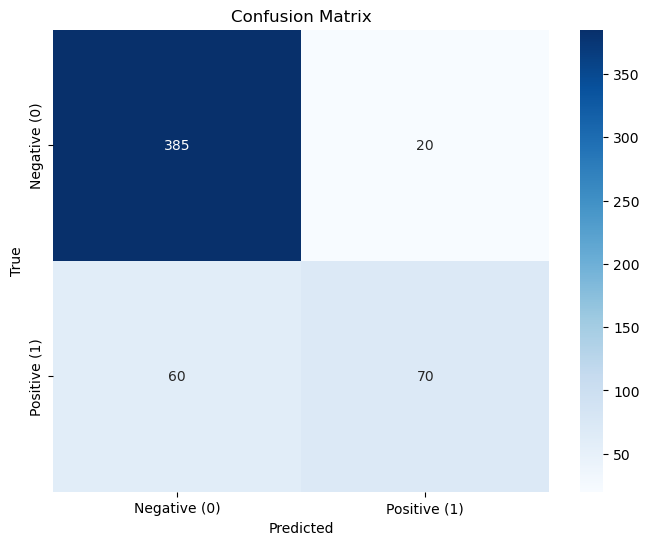

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = siec1.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


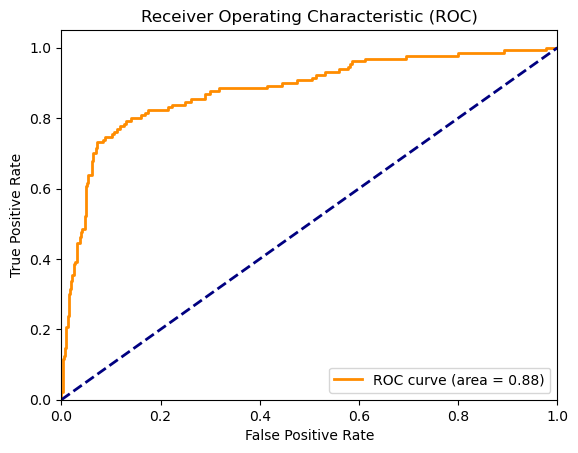

In [102]:
import matplotlib.pyplot as plt

y_pred_prob = siec1.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [103]:
# Przygotowanie modelu sieci neuronowej z regularizacją i Dropout
siec2 = Sequential()
siec2.add(Dense(2, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
siec2.add(Dropout(0.2))
siec2.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
siec2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Wczesne zatrzymanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Uczenie modelu z walidacją
siec2.fit(X_train, y_train, epochs=100, batch_size=10, 
          validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Bartosz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7047 - loss: 0.7330 - val_accuracy: 0.7477 - val_loss: 0.6492
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7538 - loss: 0.6611 - val_accuracy: 0.7726 - val_loss: 0.5920
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7633 - loss: 0.6075 - val_accuracy: 0.7788 - val_loss: 0.5446
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7744 - loss: 0.5634 - val_accuracy: 0.8069 - val_loss: 0.5021
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7848 - loss: 0.5333 - val_accuracy: 0.8224 - val_loss: 0.4698
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.5100 - val_accuracy: 0.8411 - val_loss: 0.4467
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.8075 - loss: 0.4858 - val_accuracy: 0.8349 - val_loss: 0.4290
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7925 - loss: 0.4962 - val_accuracy: 0.83

In [104]:
metrics(siec2)

Metryki dla zbioru treningowego
--------------------------------------------------
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8759351620947631
Confusion Matrix:
 [[1157   56]
 [ 143  248]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1213
           1       0.82      0.63      0.71       391

    accuracy                           0.88      1604
   macro avg       0.85      0.79      0.82      1604
weighted avg       0.87      0.88      0.87      1604

Metryki dla zbioru testowego
--------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
Accuracy: 0.8579439252336448
Confusion Matrix:
 [[387  18]
 [ 58  72]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       405
           1       0.80      0.55      0.65       130

    accuracy                           0.86       535
   macro avg      

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


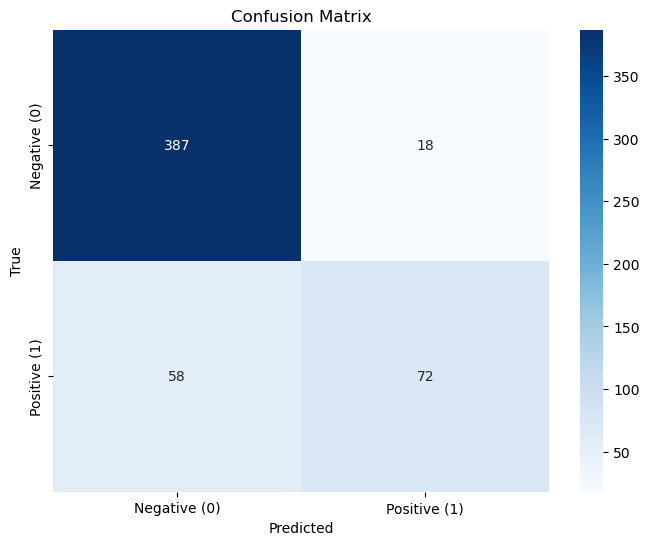

In [105]:
y_pred_prob = siec2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


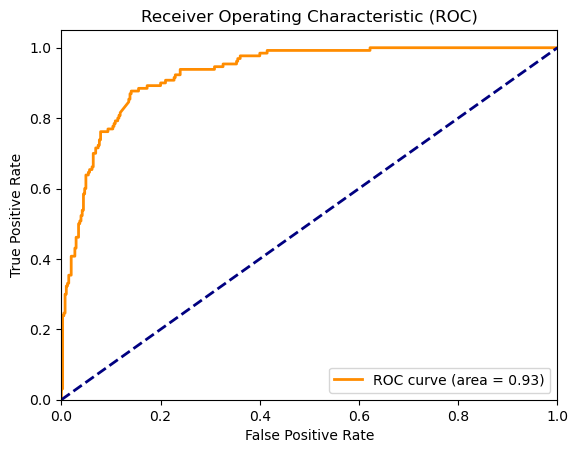

In [106]:
y_pred_prob = siec2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [107]:
# Przygotowanie bardziej złożonego modelu sieci neuronowej
siec3 = Sequential()
siec3.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
siec3.add(Dropout(0.2))
siec3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
siec3.add(Dropout(0.2))
siec3.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
siec3.add(Dropout(0.2))
siec3.add(Dense(1, activation='sigmoid'))

# Kompilacja modelu
siec3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Wczesne zatrzymanie z bardziej elastycznymi ustawieniami
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Uczenie modelu z walidacją
siec3.fit(X_train, y_train, epochs=100, batch_size=32, 
          validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\Bartosz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7684 - loss: 0.6513 - val_accuracy: 0.7414 - val_loss: 0.5551
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7739 - loss: 0.5494 - val_accuracy: 0.8287 - val_loss: 0.4654
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.4992 - val_accuracy: 0.8629 - val_loss: 0.4201
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8338 - loss: 0.4589 - val_accuracy: 0.8723 - val_loss: 0.3995
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.4660 - val_accuracy: 0.8754 - val_loss: 0.3857
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.4260 - val_accuracy: 0.8785 - val_loss: 0.3758
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8626 - loss: 0.4118 - val_accuracy: 0.8785 - val_loss: 0.3652
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.4010 - val_accuracy: 0.8816 - val_loss: 0.3

In [108]:
metrics(siec3)

Metryki dla zbioru treningowego
--------------------------------------------------
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9345386533665836
Confusion Matrix:
 [[1175   38]
 [  67  324]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1213
           1       0.90      0.83      0.86       391

    accuracy                           0.93      1604
   macro avg       0.92      0.90      0.91      1604
weighted avg       0.93      0.93      0.93      1604

Metryki dla zbioru testowego
--------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
Accuracy: 0.8934579439252337
Confusion Matrix:
 [[387  18]
 [ 39  91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       405
           1       0.83      0.70      0.76       130

    accuracy                           0.89       535
   macro avg      

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


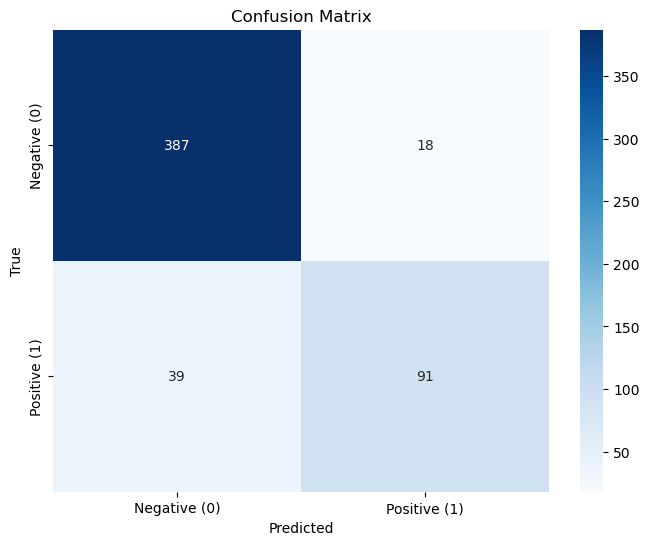

In [109]:
y_pred_prob = siec3.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


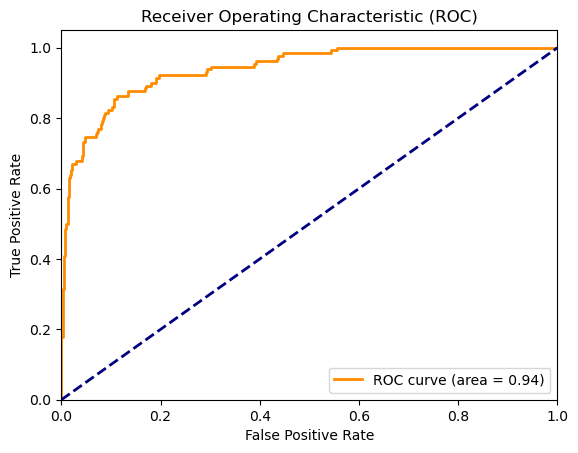

In [110]:
y_pred_prob = siec3.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()